# Coursework 2 - Mathematical Methods for Bioengineers

**Author**: Jorge Bennasar Vázquez | **CID**: 01809233

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt
import scipy.stats as stats
import networkx as nx
import scipy.io as sio
import seaborn as sns

# Download the following packages:

# pip install seaborn
# pip install networkx

In [2]:
# Load data:

mat_contents_1 = sio.loadmat('cw1_data1.mat')
fs = mat_contents_1['fs'].flatten()[0]

mat_contents_2 = sio.loadmat('cw1_data2.mat')
dFonF = mat_contents_2['dFonF']

L = np.size(dFonF[0],0)
t_im = np.linspace(0,L*1/fs,L)
N = 75

<div style="text-align: justify"> The objective of this coursework is to analyse the activity of a population of neurons through the lens of graph theory. The uploaded data corresponds to the fluorescence time series obtained by calcium imaging of 75 pyramidal neurons in the hippocampal region CA1 while a mouse is running around a circular track. This document consists of seven different sections: </div>

## Section 1

#### Filtering:

<div style="text-align: justify"> First of all, the data was filtered so that the noise did not disturb the analysis. For that, an order 5 highpass Butterworth filter was applied to the time series of the different neurons to detect the noise. The cutoff frequency was 0.1 Hz. Later, the filtered data was subtracted to the original time series to obtain smoother signals. </div>

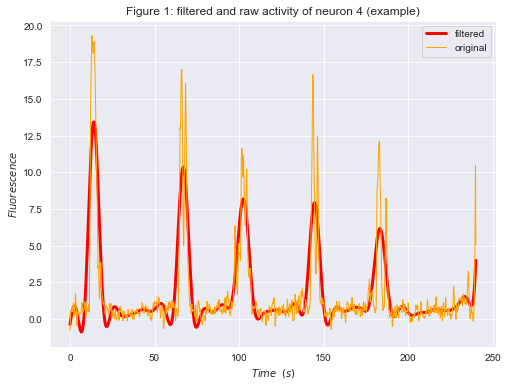

In [17]:
# Butterworth filter:

filt_dFonF = [] # filtered data

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

for i in range(N):
    x = butter_highpass_filter(dFonF[i,:], 0.1, fs) # order = 5, cutoff frequency = 0.1 Hz
    filt_dFonF.append(dFonF[i,:] - x)
    
# Plot of filtered and raw activity of neuron 4 as an example:

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(x=t_im, y=filt_dFonF[3], color='red', linewidth=3, label='filtered')
sns.lineplot(x=t_im, y=dFonF[3], color='orange', linewidth=1, label='original')
plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Fluorescence$')
plt.title('Figure 1: filtered and raw activity of neuron 4 (example)')
plt.legend()

<div style="text-align: justify"> As it is observable in Figure 1, the data is now much clearer. </div>

#### Detrending:

<div style="text-align: justify"> The next step was to detrend the data to remove possible trends that might have disturbed the analysis. This was done with two methods: a polynomial fit of order 4 and a linear fit. </div>

###### Linear fit:

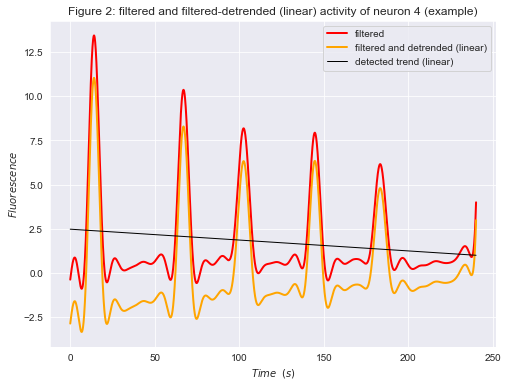

In [18]:
# Linear detrend:

lin_det_dFonF = detrend(filt_dFonF) # detrended (linear) and filtered data
lin_det_trend = filt_dFonF - lin_det_dFonF # linear trend

# Plot of filtered and filtered-detrended activity of neuron 4 as an example:

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(x=t_im, y=filt_dFonF[3], color='red', linewidth=2, label='filtered')
sns.lineplot(x=t_im, y=lin_det_dFonF[3], color='orange', linewidth=2, label='filtered and detrended (linear)')
sns.lineplot(x=t_im, y=lin_det_trend[3], color='black', linewidth=1, label='detected trend (linear)')
plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Fluorescence$')
plt.title('Figure 2: filtered and filtered-detrended (linear) activity of neuron 4 (example)')
plt.legend()

###### Polynomial fit:

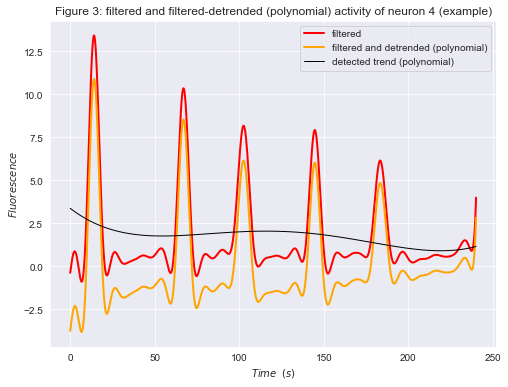

In [19]:
# Polynomial detrend:

pol_det_dFonF = [] # detrended (polynomial) and filtered data
pol_det_trend = [] # polynomial trend

for i in range(N):
    x_4, x_3, x_2, x_1, x_0 = np.polyfit(t_im, filt_dFonF[i], 4) # order 4 polynomial fit
    x = np.linspace(0, t_im[-1], np.size(filt_dFonF[i]))
    pol_det_dFonF.append(filt_dFonF[i] - (x_4*x**4 + x_3*x**3 + x_2*x**2 + x_1*x + x_0))
    pol_det_trend.append(filt_dFonF[i] - pol_det_dFonF[i])
    
# Plot of filtered and filtered-detrended activity of neuron 4 as an example:
    
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(x=t_im, y=filt_dFonF[3], color='red', linewidth=2, label='filtered')
sns.lineplot(x=t_im, y=pol_det_dFonF[3], color='orange', linewidth=2, label='filtered and detrended (polynomial)')
sns.lineplot(x=t_im, y=pol_det_trend[3], color='black', linewidth=1, label='detected trend (polynomial)')
plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Fluorescence$')
plt.title('Figure 3: filtered and filtered-detrended (polynomial) activity of neuron 4 (example)')
plt.legend()

<div style="text-align: justify"> However, figures 2 and 3 clearly show that both linear and polynomial detrending pervert the data instead of removing the effect of slow covariations. This is because the detected tendencies are inaccurate: the different strengths of the spikes create fictitious trends that distort the analysis. The data used for the analysis, therefore, is filtered but non-detrended. </div>

#### Weighted adjacent matrix:

<div style="text-align: justify"> Later on, the weighted adjacent matrix of the data was obtained and plotted, as shown below (Figure 4). The elements of the matrix are the Pearson correlation coefficients between the fluorescence time series of the different neurons. The Pearson coefficient measures the linear correlation between two signals. Its values range from -1 (total inverse correlation) to 1 (total direct correlation). A value of zero means no linear correlation and suggests that the studied signals have no significant relationship. </div>

Text(0.5, 1, 'Figure 4: weighted adjacent matrix')

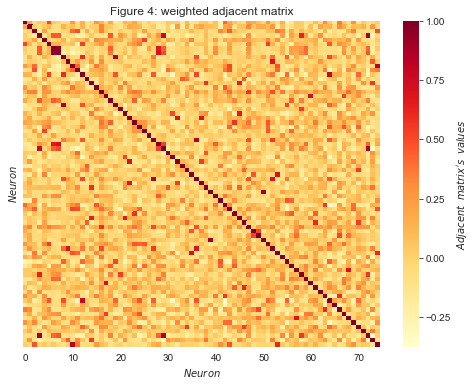

In [13]:
# Creation and plotting of the weighted adjacent matrix:

r_matrix = np.corrcoef(filt_dFonF) # matrix of Pearson correlation coefficients
w_adj_matrix = r_matrix

plt.figure(figsize=(8,6))
sns.heatmap(w_adj_matrix, xticklabels=10, yticklabels=False, cmap="YlOrRd", cbar_kws={'label': "$Adjacent$  $matrix's$  $values$"})
plt.xlabel('$Neuron$')
plt.ylabel('$Neuron$')
plt.title('Figure 4: weighted adjacent matrix')

<div style="text-align: justify"> Figure 4 clearly shows the strength of the correlation between the different neurons. As it is visible, the matrix's trace is dark red. This is because the Pearson correlation coefficient of each signal with itself is of 1. </div>

#### Graph of connections of weighted adjacent matrix:

<div style="text-align: justify"> Afterwards, a graph of connections was plotted (Figure 5). Note that this graph (as the ones shown below) is undirected: correlations are bidirectional. The nodes represent each neuron, while the edges represent the different correlations between them. For positive correlations, yellow and slim edges exemplify weak correlation coefficients, while red and wider ones are representative of strong correlations. For negative ones, weak correlations are represented with thin light-blue links and strong correlations with thick dark-blue edges. Take into account that the width of the lines depends on the absolute value of the Pearson correlation coefficient: negative correlations may also be relevant in this analysis. This is because negative correlations may give valuable information about how neurons work against each other (inhibitions etc.). </div>

Text(0.5, 1.0, 'Figure 5: connections between neurons')

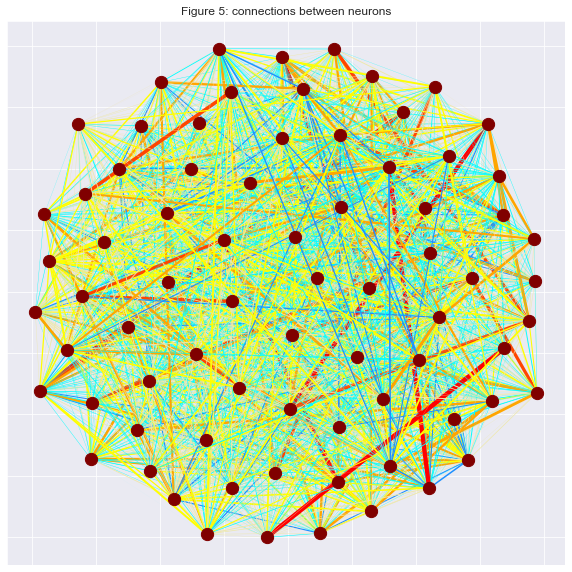

In [9]:
# Creation and plotting of the graph of connections of the weighted adjacent matrix:

G_1 = nx.Graph() # generation of the graph

for i in range(N): # the edges are added with their respective width and color (depending on the absolute value of the Pearson correlation coefficient)
    for j in range(N):
        if w_adj_matrix[i][j] <= -0.4:
            G_1.add_edge(i, j, color='blue', weigth=abs(w_adj_matrix[i][j])*5)
        if w_adj_matrix[i][j] > -0.4 and w_adj_matrix[i][j] <= -0.2:
            G_1.add_edge(i, j, color='dodgerblue', weigth=abs(w_adj_matrix[i][j])*5)
        if w_adj_matrix[i][j] > -0.2 and w_adj_matrix[i][j] <= 0:
            G_1.add_edge(i, j, color='aqua', weigth=abs(w_adj_matrix[i][j])*5)
        if w_adj_matrix[i][j] > 0 and w_adj_matrix[i][j] <= 0.2:
            G_1.add_edge(i, j, color='palegoldenrod', weigth=abs(w_adj_matrix[i][j])*5)
        if w_adj_matrix[i][j] > 0.2 and w_adj_matrix[i][j] <= 0.4:
            G_1.add_edge(i, j, color='yellow', weigth=abs(w_adj_matrix[i][j])*5)
        if w_adj_matrix[i][j] > 0.4 and w_adj_matrix[i][j] <= 0.6:
            G_1.add_edge(i, j, color='orange', weigth=abs(w_adj_matrix[i][j])*5)
        if w_adj_matrix[i][j] > 0.6 and w_adj_matrix[i][j] <= 0.8:
            G_1.add_edge(i, j, color='orangered', weigth=abs(w_adj_matrix[i][j])*5)
        if w_adj_matrix[i][j] > 0.8:
            G_1.add_edge(i, j, color='red', weigth=abs(w_adj_matrix[i][j])*5)
            
edges = G_1.edges()
colors = [G_1[u][v]['color'] for u,v in edges]
weights = [G_1[u][v]['weigth'] for u,v in edges]

pos = nx.spring_layout(G_1)
node_color = 'maroon'
plt.figure(figsize=(10,10))
nx.draw_networkx(G_1, pos=pos, with_labels=False, node_size = 150, node_color=node_color, edge_color=colors, width=weights)
plt.title('Figure 5: connections between neurons')

<div style="text-align: justify"> In the graph above all nodes are connected. This is because no correlation is zero. However, most of the edges are thin, demonstrating small correlations (close to zero) which could have no relevance in the study. Only some nodes are strongly related. This suggests that a threshold should be set to remove all weak connections from the graph. It is also important to note that negative correlations tend to be weaker than positive ones, which makes sense taking into account that closely located neurons tend to fire together. This is visible in the graph, where the positive correlation edges get to be thicker than negative ones. </div>

## Section 2

#### Binarised adjacent matrix (threshold = 0.123):

<div style="text-align: justify"> The first step in section 2 was to set the threshold for removing the weak connections. To do this, the mean of the weighted adjacent matrix's absolute values (without the trace) was computed. The trace was removed because the correlation of one neuron with itself does not give any information of value. </div>

Threshold:  0.123


Text(0.5, 1, 'Figure 6: binarised adjacent matrix (threshold = 0.123)')

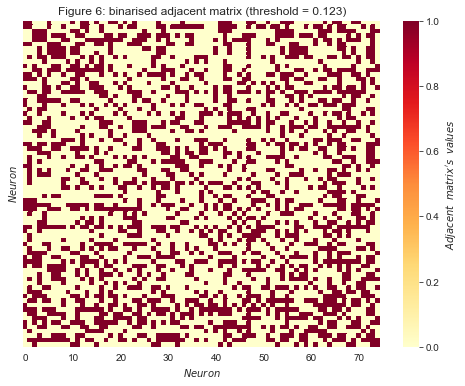

In [12]:
# Application of the threshold to create the binarised adjacent matrix:

threshold = (np.sum(abs(w_adj_matrix)) - N)/(N*(N-1)) # the threshold is the mean of the Pearson correlation coefficients without taking into account the trace of autocorrelations

binary_w_adj_matrix = (abs(w_adj_matrix) > threshold).astype(np.int_)

threshold = round(threshold, 3)
print('Threshold: ', threshold)

# Plot of the binarised adjacent matrix:

plt.figure(figsize=(8,6))
sns.heatmap(binary_w_adj_matrix, xticklabels=10, yticklabels=False, cmap="YlOrRd", cbar_kws={'label': "$Adjacent$  $matrix's$  $values$"})
plt.xlabel('$Neuron$')
plt.ylabel('$Neuron$')
plt.title('Figure 6: binarised adjacent matrix (threshold = 0.123)')

<div style="text-align: justify"> As it is visible in Figure 6, the matrix is now binary: red dots represent connected nodes. From the matrix, it is possible to infer that at least half of the links have been removed. This will help in the analysis. </div>

#### Graph of connections after setting the threshold (threshold = 0.123):

<div style="text-align: justify"> Later on, the new graph of connections was plotted (Figure 7). For this, the binarisation was taken into account to remove the undesired edges, but the non-removed ones were represented following the same criteria as the one used for the previous graph (Figure 5). </div>

Text(0.5, 1.0, 'Figure 7: connections between neurons')

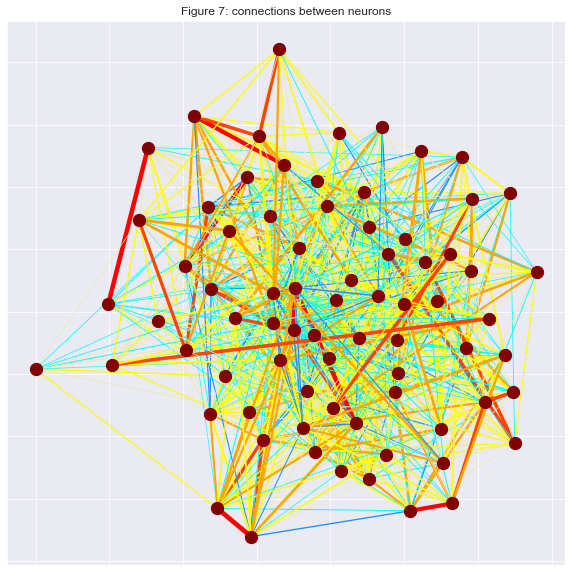

In [14]:
# Creation and plotting of the graph of connections of the binarised adjacent matrix:

G_2 = nx.Graph()

for i in range(N):
    for j in range(N):
        if binary_w_adj_matrix[i][j] == True:
            if w_adj_matrix[i][j] <= -0.4:
                G_2.add_edge(i, j, color='blue', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > -0.4 and w_adj_matrix[i][j] <= -0.2:
                G_2.add_edge(i, j, color='dodgerblue', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > -0.2 and w_adj_matrix[i][j] <= 0:
                G_2.add_edge(i, j, color='aqua', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0 and w_adj_matrix[i][j] <= 0.2:
                G_2.add_edge(i, j, color='palegoldenrod', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0.2 and w_adj_matrix[i][j] <= 0.4:
                G_2.add_edge(i, j, color='yellow', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0.4 and w_adj_matrix[i][j] <= 0.6:
                G_2.add_edge(i, j, color='orange', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0.6 and w_adj_matrix[i][j] <= 0.8:
                G_2.add_edge(i, j, color='orangered', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0.8:
                G_2.add_edge(i, j, color='red', weigth=abs(w_adj_matrix[i][j])*5)

edges = G_2.edges()
colors = [G_2[u][v]['color'] for u,v in edges]
weights = [G_2[u][v]['weigth'] for u,v in edges]
node_color = 'maroon'

pos = nx.spring_layout(G_2)
plt.figure(figsize=(10,10))
nx.draw_networkx(G_2, pos=pos, with_labels=False, node_size = 150, node_color=node_color, edge_color=colors, width=weights)
plt.title('Figure 7: connections between neurons')

<div style="text-align: justify"> Many connections have now been removed, but weak connections are still present. In this graph, it is even more visible how positive correlations are dominant. </div>

## Section 3

#### Average degree and connectivity (threshold = 0.123):

<div style="text-align: justify"> In section 3 the average degree and the connectivity of the binarised adjacent matrix are calculated. The degree of a node (k) represents the number of links that this node has to other ones. The average degree is just the average of the degrees of all 75 nodes. The connectivity is the percentage of connected nodes. </div>

In [24]:
# Calculation of the average degree and the connectivity:

L = (np.sum(binary_w_adj_matrix) - N)/2 # L is the number of undirected edges
average_degree = 2*L/N
average_degree = round(average_degree, 3)
print('Average degree: ', average_degree)
connectivity = average_degree*100/(N-1)
connectivity = round(connectivity, 3)
print('Connectivity: ', connectivity, '%')

Average degree:  27.227
Connectivity:  36.793 %


<div style="text-align: justify"> The average degree of the graph in Figure 6 is 27.23, while the one of the graph shown in Figure 4 (before applying the threshold) is 74 (all neurons are connected with each other). This means that, while the previous connectivity was of 100%, now it is of 36.8%: 63.2% of edges were removed by setting the threshold. </div>

## Section 4

#### Global clustering coefficient (threshold = 0.123):

<div style="text-align: justify"> Later on, the global clustering coefficient (gC) of the "filtered" (binarised) adjacent matrix was calculated. The clustering coefficient (C) of each node expresses the degree in which its neighbours are connected to each other, from 0 (no connections) to 1 (all connected). For its calculation, the node cannot be isolated. The global clustering coefficient is the average of the clustering coefficients of the different nodes. </div>

In [25]:
# Global clustering coefficient calculation:

global_C = nx.algorithms.cluster.average_clustering(G_2)
global_C = round(global_C, 3)
print('Global clustering coefficient (gC): ', global_C)

# Additional calculation of the global clustering coefficient:

C = []

for i in range(N):
    L = 0 # L is the counter of connections between neighbours
    for j in range(N):
        if (binary_w_adj_matrix[i][j] == True) and (i != j):
            for k in range(N):
                if (i != k) and (j != k):
                    if (binary_w_adj_matrix[j][k] == True) and (binary_w_adj_matrix[i][k] == True):
                        L += 1
    if L == 0: C.append(0)
    else:
        C.append(L/((np.sum(binary_w_adj_matrix[i]) - 1)*
                    (np.sum(binary_w_adj_matrix[i]) - 2)))
        
add_global_C = np.mean(C)
add_global_C = round(add_global_C, 3)
print('Additional global clustering coefficient (gC): ', add_global_C)

Global clustering coefficient (gC):  0.45
Additional global clustering coefficient (gC):  0.45


<div style="text-align: justify"> The global clustering coefficient is of 0.45, as shown above. This means that the average probability of two neighbours of a node being connected is 45%. The coefficient was calculated with two different methods to assure that the result was correct. </div>

## Section 5

#### Degree distribution (threshold = 0.123):

<div style="text-align: justify"> In section 5 the degree distribution for the network is plotted. This distribution shows the probability for a node to have a given degree (number of connections). Of course, the mean of the distribution is the average degree calculated in section 3. </div>

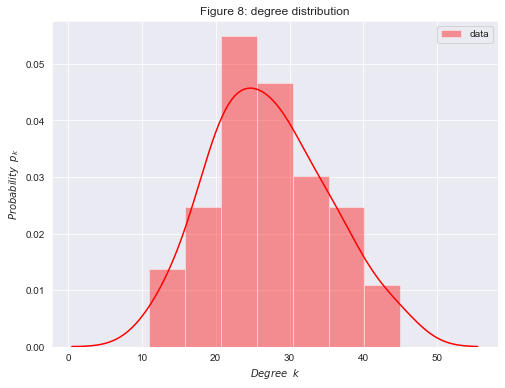

In [26]:
# Plot of the degree distribution:

x = np.sum(binary_w_adj_matrix,1) - 1 # one is subtracted to eliminate the effect of the autocorrelation

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.distplot(x, color='red', label='data')
plt.xlabel('$Degree$  $k$')
plt.ylabel('$Probability$  $p_k$')
plt.title('Figure 8: degree distribution')
plt.legend()

<div style="text-align: justify"> In Figure 8 the probability histogram is accompanied by an approximation of the continuous distribution. The distribution is close to normal, as shown below (Figure 9): </div>

Text(0, 0.5, '$Ordered$  $values$')

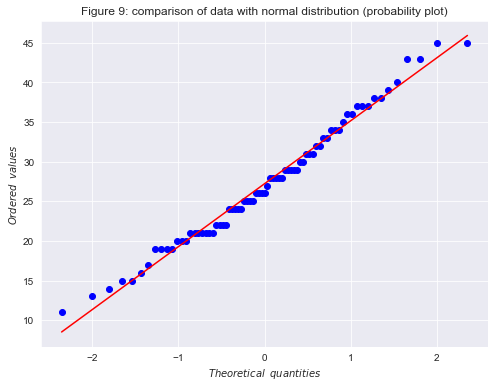

In [27]:
# Comparison of data with normal distribution

plt.figure(figsize=(8,6))
res = stats.probplot(x, plot=plt) # probability plot
plt.title('Figure 9: comparison of data with normal distribution (probability plot)')
plt.xlabel('$Theoretical$  $quantities$')
plt.ylabel('$Ordered$  $values$')

#### Random Erdos-Renyi graph (p = 0.368):

<div style="text-align: justify"> A random Erdos-Renyi graph was later created. In an Erdos-Renyi model of "N" nodes, each edge between nodes has a fixed probability "p" of being present (Gilbert variant). The presence of one edge is independent of the others. Note that the probability of connection in the Erdos-Renyi graph is the connectivity of the data-derived network (p = 0.368 = 36.8% = connectivity). </div>

In [28]:
# Creation of the random Erdos-Renyi graph:

p = average_degree/(N-1) # probability of connection
G_3 = nx.erdos_renyi_graph(N, p)
p = round(p, 3)

# Calculation of the global clustering coefficient of the Erdos-Renyi graph:

rdm_global_C = nx.algorithms.cluster.average_clustering(G_3)
rdm_global_C = round(rdm_global_C, 3)
print('Global clustering coefficient (gC) of random network: ', rdm_global_C)
print("Probability (p) that two of i's neighbours link to each other: ", p)
print('Note that: p ≃ gC')

Global clustering coefficient (gC) of random network:  0.374
Probability (p) that two of i's neighbours link to each other:  0.368
Note that: p ≃ gC


<div style="text-align: justify"> As stated above, note that the global clustering coefficient (gC) is nearly equal to the probability "p". This is because the probability that two of i's neighbours link to each other, measured by "gC", is equivalent to the probability that two aleatory nodes are connected (p). In an infinitely big network "gC" would converge to the value of "p". This would happen as long as the connections between nodes are random. Below, the random Erdos-Renyi network is plotted (Figure 10). </div>

Text(0.5, 1.0, 'Figure 10: connections between neurons (Random Erdos-Renyi)')

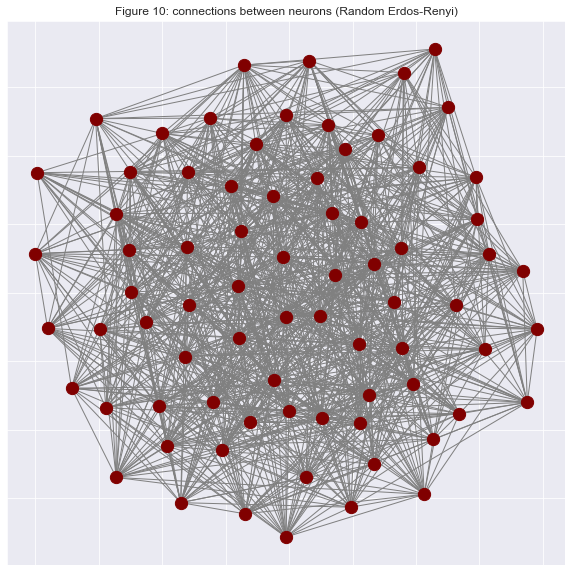

In [29]:
# Plot of the Erdos-Renyi graph:

pos = nx.spring_layout(G_3)
colors= 'grey'
node_color = 'maroon'
plt.figure(figsize=(10,10))
nx.draw_networkx(G_3, pos=pos, with_labels=False, node_size = 150, node_color=node_color, edge_color=colors)
plt.title('Figure 10: connections between neurons (Random Erdos-Renyi)')

#### Comparison of degree distributions (threshold = 0.123):

<div style="text-align: justify"> To end section 5, the degree distribution of the random network was plotted together with the one correspondent to the data (Figure 11). Note that the distributions differ greatly. There is one main reason for this: in an Erdos-Renyi network the connections between nodes are aleatory, while in the brain correlations of activity (i.e. edges) between neurons depend on their proximity (and, of course, other factors). The tales of the real distribution (derived from the data) show that there are highly interconnected neurons and poorly interconnected ones. </div>

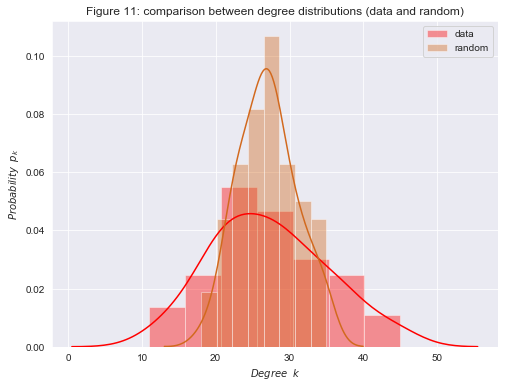

In [30]:
# Comparison between the degree distributions of the data and the Erdos-Renyi graph:

y = [G_3.degree(u) for u in G_3.nodes()]

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.distplot(x, color='red', label='data')
sns.distplot(y, color='chocolate', label='random')
plt.xlabel('$Degree$  $k$')
plt.ylabel('$Probability$  $p_k$')
plt.title('Figure 11: comparison between degree distributions (data and random)')
plt.legend()

## Section 6

#### Binarised adjacent matrix, average degree and connectivity (threshold = 0.362):

<div style="text-align: justify"> Later, in section 6, the same process was repeated for another threshold. The threshold (0.362) was selected for a connectivity of 5%. For this, the threshold was changed until the resultant connectivity was the desired one. </div>

In [31]:
# Application of the threshold for 5% connectivity:

threshold = 0.362
print('Threshold: ', threshold)

binary_w_adj_matrix = (abs(w_adj_matrix) > threshold).astype(np.int_)

# Calculation of the average degree and the connectivity:

L = (np.sum(binary_w_adj_matrix) - N)/2
average_degree = 2*L/N
average_degree = round(average_degree, 3)
print('Average degree: ', average_degree)
connectivity = average_degree*100/(N-1)
connectivity = round(connectivity, 3)
print('Connectivity: ', connectivity, '%')

Threshold:  0.362
Average degree:  3.707
Connectivity:  5.009 %


<div style="text-align: justify"> The new binarised adjacent matrix is plotted below (Figure 12): </div>

Text(0.5, 1, 'Figure 12: binarised adjacent matrix (threshold = 0.362)')

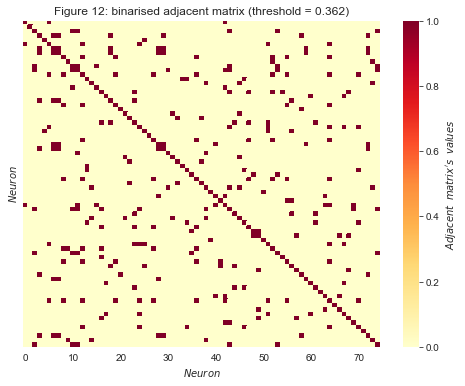

In [32]:
# Plot of the binarised adjacent matrix:

plt.figure(figsize=(8,6))
sns.heatmap(binary_w_adj_matrix, xticklabels=10, yticklabels=False, cmap="YlOrRd", cbar_kws={'label': "$Adjacent$  $matrix's$  $values$"})
plt.xlabel('$Neuron$')
plt.ylabel('$Neuron$')
plt.title('Figure 12: binarised adjacent matrix (threshold = 0.362)') 

<div style="text-align: justify"> As it is observable above, now there are much fewer connections than in the case analysed in sections 2-5. </div>

#### Graph of connections after setting the threshold (threshold = 0.362):

<div style="text-align: justify"> Afterwards, the new graph of connections was plotted (Figure 13). This new graph shows isolated nodes (neurons) that do not have a strong correlation (absolute value above 0.362) with any other cell. Only one negative correlation is present in the graph with the new threshold. </div>

Text(0.5, 1.0, 'Figure 13: connections between neurons')

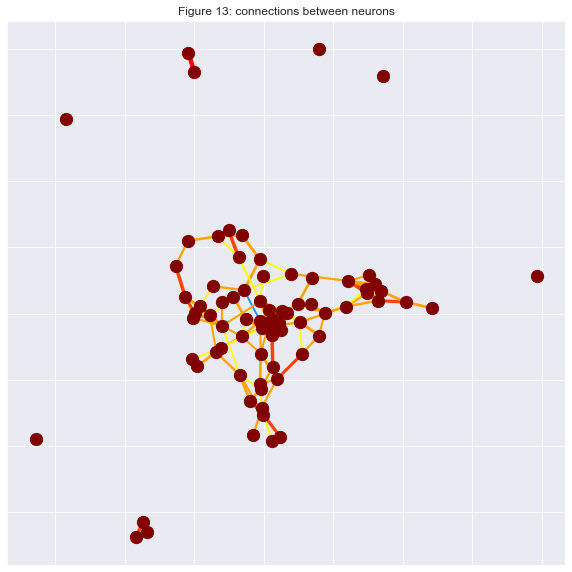

In [21]:
# Creation and plotting of the graph of connections of the binarised adjacent matrix:

G_4 = nx.Graph()

for i in range(N):
    for j in range(N):
        if binary_w_adj_matrix[i][j] == True:
            if w_adj_matrix[i][j] <= -0.4:
                G_4.add_edge(i, j, color='blue', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > -0.4 and w_adj_matrix[i][j] <= 0:
                G_4.add_edge(i, j, color='dodgerblue', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0 and w_adj_matrix[i][j] <= 0.4:
                G_4.add_edge(i, j, color='yellow', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0.4 and w_adj_matrix[i][j] <= 0.6:
                G_4.add_edge(i, j, color='orange', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0.6 and w_adj_matrix[i][j] <= 0.8:
                G_4.add_edge(i, j, color='orangered', weigth=abs(w_adj_matrix[i][j])*5)
            if w_adj_matrix[i][j] > 0.8:
                G_4.add_edge(i, j, color='red', weigth=abs(w_adj_matrix[i][j])*5)

edges = G_4.edges()
colors = [G_4[u][v]['color'] for u,v in edges]
weights = [G_4[u][v]['weigth'] for u,v in edges]
node_color = 'maroon'

pos = nx.spring_layout(G_4)
plt.figure(figsize=(10,10))
nx.draw_networkx(G_4, pos=pos, with_labels=False, node_size = 150, node_color=node_color, edge_color=colors, width=weights)
plt.title('Figure 13: connections between neurons')

#### Global clustering coefficient (threshold = 0.362):

<div style="text-align: justify"> The global clustering coefficient was then calculated for the new binarised adjacent matrix: </div>

In [281]:
# Global clustering coefficient calculation:

global_C = nx.algorithms.cluster.average_clustering(G_4)
global_C = round(global_C, 3)
print('Global clustering coefficient (gC): ', global_C)

# Relationships in connectivity and global clustering coefficient:

rel_connectivity = 5/36.8
rel_connectivity = round(rel_connectivity, 3)
print('Relationship of connectivities (threshold = 0.362 / threshold = 0.123): ', rel_connectivity)
rel_gC = 0.383/0.45
rel_gC = round(rel_gC, 3)
print('Relationship of "gC" (threshold = 0.362 / threshold = 0.123): ', rel_gC)

Global clustering coefficient (gC):  0.383
Relationship of connectivities (threshold = 0.362 / threshold = 0.123):  0.136
Relationship of "gC" (threshold = 0.362 / threshold = 0.123):  0.851


<div style="text-align: justify"> It is interesting to note that the global clustering coefficient does not change that much from the one calculated for the previous threshold (from 0.45 to 0.383). This is because the fact that there is much less connectivity (from 36.8% to 5%) does not necessarily mean that the neighbour nodes have unlinked at the same ratio. This is intuitive: as we put a higher threshold, we detect groups of strongly correlated neurons with similar behaviours, and therefore the "gC" does not fall drastically. </div>

#### Degree distribution (threshold = 0.362):

<div style="text-align: justify"> Later on, the new degree distribution was plotted (Figure 14). In the figure, it is visible that the new degree distribution is far from normal. </div>

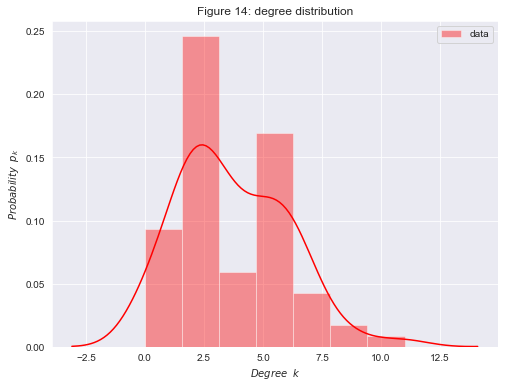

In [34]:
# Plot of the degree distribution:

x = np.sum(binary_w_adj_matrix,1) - 1

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.distplot(x, color='red', label='data')
plt.xlabel('$Degree$  $k$')
plt.ylabel('$Probability$  $p_k$')
plt.title('Figure 14: degree distribution')
plt.legend()

#### Random Erdos-Renyi graph (p = 0.05):

<div style="text-align: justify"> Afterwards, a new Erdos-Renyi graph (p = 0.05) was created and plotted (Figure 15): </div>

Global clustering coefficient (gC) of random network:  0.064


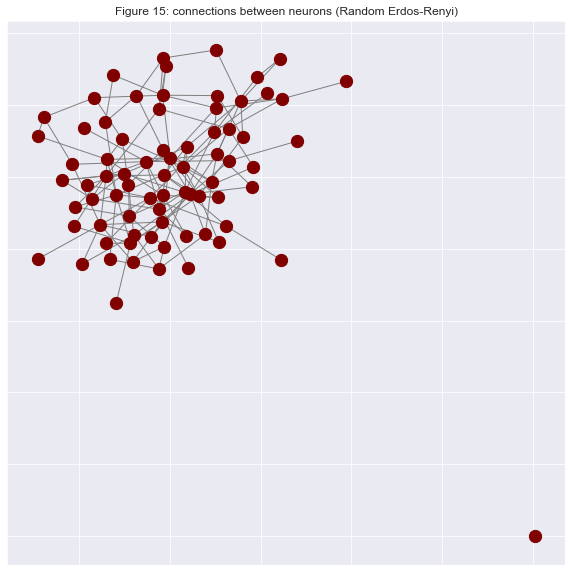

In [38]:
# Creation and plotting of the random Erdos-Renyi graph:

p = average_degree/(N-1)
G_5 = nx.erdos_renyi_graph(N, p)

pos = nx.spring_layout(G_5)
colors= 'grey'
node_color = 'maroon'
plt.figure(figsize=(10,10))
nx.draw_networkx(G_5, pos=pos, with_labels=False, node_size = 150, node_color=node_color, edge_color=colors)
plt.title('Figure 15: connections between neurons (Random Erdos-Renyi)')

# Calculation of the global clustering coefficient of the Erdos-Renyi graph:

rdm_global_C = nx.algorithms.cluster.average_clustering(G_5)
rdm_global_C = round(rdm_global_C, 3)
print('Global clustering coefficient (gC) of random network: ', rdm_global_C)

<div style="text-align: justify"> It is important to note that the new random graph has a global clustering coefficient (gC) of 0.064, which is much smaller than the one of the network derived from the data (0.383). This is discussed in section 7. </div>

#### Comparison of degree distributions (threshold = 0.362):

<div style="text-align: justify"> As it is visible in Figure 16, where both degree distributions (random and data) are plotted together, a lower connectivity (5%) gives similar behaviours (regarding the degree distribution) between the Erdos-Renyi graph and the one derived from the neural activity. </div>

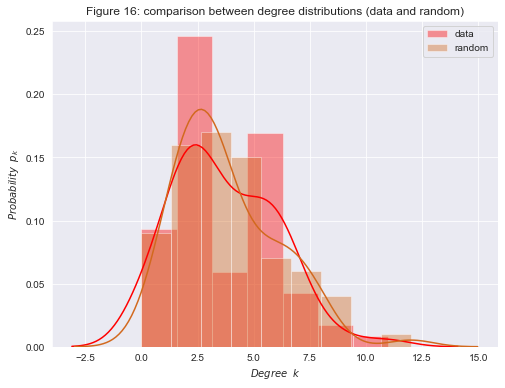

In [40]:
# Comparison between the degree distributions of the data and the Erdos-Renyi graph:

y = [G_5.degree(u) for u in G_5.nodes()]

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.distplot(x, color='red', label='data')
sns.distplot(y, color='chocolate', label='random')
plt.xlabel('$Degree$  $k$')
plt.ylabel('$Probability$  $p_k$')
plt.title('Figure 16: comparison between degree distributions (data and random)')
plt.legend()

## Section 7

<div style="text-align: justify"> The purpose of section 7 is to analyse what model (scale-free, small-world or random) better describes the behaviour of the data: </div>

#### Scale-free:

<div style="text-align: justify"> Scale-free networks are characterised by having important hubs, which are nodes with a lot of connections. Additionally, their degree distributions tend to follow a power law. However, neither of the aforementioned characteristics are present in the analysed network. Therefore, it is possible to say that the network is not well described by a scale-free model. </div>

#### Small-world vs Erdos-Renyi (random):

<div style="text-align: justify"> Small-world networks are those in which most nodes are not connected between each other, but the majority of them can be reached after a small number of steps. This means that the global clustering coefficient of small-world networks is significantly higher than that of Erdos-Renyi ones. This is the main difference between both approaches. </div>

<div style="text-align: justify"> In the context of a binarised adjacent matrix created by setting a threshold on the correlation, the global clustering coefficient of a small-world network would decrease at a slower pace than that of a random one. To determine what model better explains the neural behaviour, the relations between the global clustering coefficient and the threshold for both the data-derived and the random networks were plotted (Figure 17): </div>

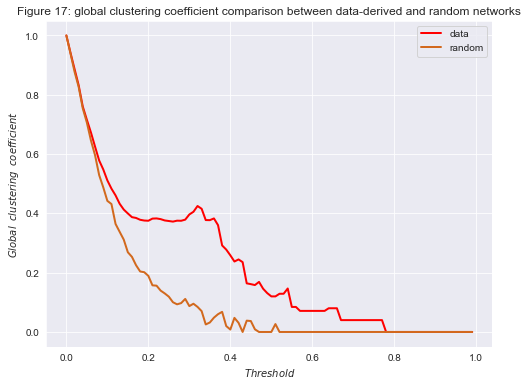

In [43]:
# Global clustering coefficient comparison between data-derived and random networks:

threshold_vec = []
data_gC_vec = []
ran_gC_vec = []
p_vec = []

for i in range(100): # for 100 thresholds between 0 and 1
    
    threshold = 0.01*i
    threshold_vec.append(threshold)
    binary_w_adj_matrix = (abs(w_adj_matrix) > threshold).astype(np.int_)

    G = nx.Graph()
    for i in range(N): 
        for j in range(N): 
            if binary_w_adj_matrix[i][j] == True: G.add_edge(i, j)
    data_gC_vec.append(nx.algorithms.cluster.average_clustering(G)) # data-derived gC
    
    L = (np.sum(binary_w_adj_matrix) - N)/2
    average_degree = 2*L/N
    p = average_degree/(N-1)
    p_vec.append(p) # probability of connection
    
    G = nx.erdos_renyi_graph(N, p)
    ran_gC_vec.append(nx.algorithms.cluster.average_clustering(G)) # Erdos-Renyi gC

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(x=threshold_vec, y=data_gC_vec, color='red', linewidth=2, label='data')
sns.lineplot(x=threshold_vec, y=ran_gC_vec, color='chocolate', linewidth=2, label='random')
plt.xlabel('$Threshold$')
plt.ylabel('$Global$  $clustering$  $coefficient$')
plt.title('Figure 17: global clustering coefficient comparison between data-derived and random networks')
plt.legend()

<div style="text-align: justify"> With a low threshold, the global clustering coefficients decrease at a similar pace. However, when the threshold hits a value of around 0.15, the data-derived network's gradient flattens. This is a clear sign that the data is better explained by the dynamics of a small-world network. </div>

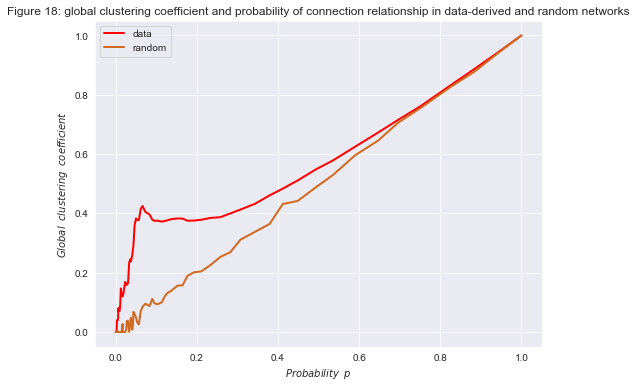

In [44]:
# Global clustering coefficient and probability of connection relationship in data-derived and random networks:

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(x=p_vec, y=data_gC_vec, color='red', linewidth=2, label='data')
sns.lineplot(x=p_vec, y=ran_gC_vec, color='chocolate', linewidth=2, label='random')
plt.xlabel('$Probability$  $p$')
plt.ylabel('$Global$  $clustering$  $coefficient$')
plt.title('Figure 18: global clustering coefficient and probability of connection relationship in data-derived and random networks')
plt.legend()

<div style="text-align: justify"> The relationship between "p" and "gC" for both networks was also plotted (Figure 18) to assure that the neural behaviour follows the dynamics of a small-world model. In the case of the Erdos-Renyi network, the global clustering coefficient should tend to be equal to the probability of connection (p ≃ gC), as stated in section 5. This is clear in the figure shown above. However, this is not the case for the data-derived network. This is another sign that the data is better described by a small-world model. This makes sense taking into account that many papers have used the small-world approach to model the complex networks of the human brain (see Small-world human brain networks: Perspectives and challenges (Liao, X., Vasilakos, A. V., & He, Y. (2017))). </div>

## Extra

#### Detection of high correlated clusters (threshold = 0.85):

<div style="text-align: justify"> As an extra, small groups with high correlations (threshold = 0.85) were studied to detect clusters of neurons that share most of their activity: </div>

Threshold:  0.85


Text(0.5, 1.0, 'Figure 19: connections between neurons')

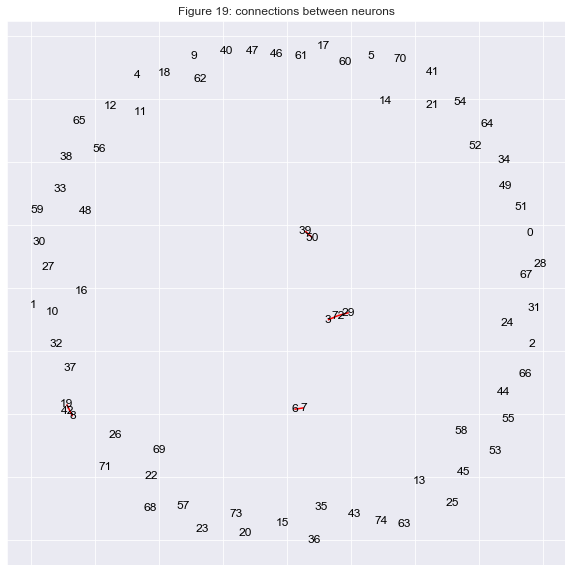

In [45]:
# Application of new high threshold to detect high correlations:

threshold = 0.85

print('Threshold: ', threshold)

binary_w_adj_matrix = (abs(w_adj_matrix) > threshold).astype(np.int_)

G_6 = nx.Graph()

for i in range(N):
    for j in range(N):
        if binary_w_adj_matrix[i][j] == True:
            if w_adj_matrix[i][j] <= 0:
                G_6.add_edge(i, j, color='blue')
            if w_adj_matrix[i][j] > 0:
                G_6.add_edge(i, j, color='red')

edges = G_6.edges()
colors = [G_6[u][v]['color'] for u,v in edges]
            
pos = nx.spring_layout(G_6)
plt.figure(figsize=(10,10))
nx.draw_networkx(G_6, pos=pos, with_labels=True, node_size = 0, edge_color=colors, width=1.5)
plt.title('Figure 19: connections between neurons')

<div style="text-align: justify"> In Figure 19 all connections are representative of positive correlations. It is interesting how neurons 4, 30 and 73 (noted in the graph as 3, 29 and 72) form a highly correlated group. This is shown in Figure 20, which suggests that the three neurons are located close to each other: they share all spikes with different intensities. </div>

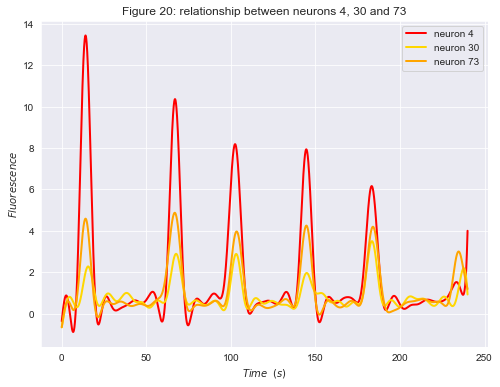

In [46]:
# Relationship between neurons 4, 30 and 73:

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(x=t_im, y=filt_dFonF[3], color='red', linewidth=2, label='neuron 4')
sns.lineplot(x=t_im, y=filt_dFonF[29], color='gold', linewidth=2, label='neuron 30')
sns.lineplot(x=t_im, y=filt_dFonF[72], color='orange', linewidth=2, label='neuron 73')
plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Fluorescence$')
plt.title('Figure 20: relationship between neurons 4, 30 and 73')
plt.legend()